## Part III : Using Multi Character context and proper neural net

- Loosely follows the 2003 paper : [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- Project every character in a high dimensional (dimension configurable) feature space 
- Use multiple character (configurable) context
- Finally use a neural net with configurable number of neurones and a tanh activation function

In [41]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# excetions show up normally
%xmode plain

# plots show up inline
%matplotlib inline

def get_device(no_gpu=False):
    """
    Returns one of cuda / mps / cpu based on availablity
    """
    if no_gpu is True:
        return torch.device("cpu")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


# Choose the default device
no_gpu = False
default_device = get_device(no_gpu)


# Needed to import modules from src
import sys
sys.path.append('..')


# Get Project Root (needed for reading config)
import os
projectRoot = os.path.dirname(os.getcwd())
print(projectRoot)

Exception reporting mode: Plain
e:\Karpathy-Makemore


#### Load Raw Data and helper functions

In [42]:
from src.loadData import get_everything, start_ch
all_data, vocab, stoi, itos = get_everything(projectRoot)

print(f"Vocab Size: {len(vocab)}")
all_data[:10]

Vocab Size: 27


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

#### Split data into train, validation and test set

In [43]:
train_percentage = 0.8
train_boundary = math.ceil(len(all_data) * train_percentage)

cv_percentage = train_percentage + 0.1
cv_boundary = math.ceil(len(all_data) * cv_percentage)

train_data = all_data[:train_boundary]
cv_data = all_data[train_boundary:cv_boundary]
test_data = all_data[cv_boundary:]

#### Create training data from the base on multi character context

In [44]:
%%time

context_size = 3

# All the following should move to a module
encode = lambda name: [stoi[ch] for ch in name] if len(name) > 1 else stoi[name]
decode = lambda ints: [itos[i] for i in ints] if isinstance(ints, list) is True else itos[ints]

def get_samples(data, context_size=3, start_ch="."):
    xs, ys = [], []
    for name in data:
        context = [start_ch] * context_size
        for ch in name:
            xs.append(encode(context))
            ys.append(encode(ch))

            context.pop(0)
            context.append(ch)
    return torch.tensor(xs, device=default_device), torch.tensor(ys, device=default_device)


Xtr, Ytr = get_samples(train_data)
Xcv, Ycv = get_samples(cv_data)
print(f"Xtr Shape: {Xtr.shape}\tYtr Shape:{Ytr.shape}")
Xtr[:5, :]

Xtr Shape: torch.Size([157157, 3])	Ytr Shape:torch.Size([157157])
CPU times: total: 219 ms
Wall time: 245 ms


tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [ 0,  0,  0]], device='cuda:0')

#### Neural Net Arch and Params

In [54]:
g = torch.Generator(device=default_device).manual_seed(2147483627)

# Projecting each character to 2 dimensional space 
feature_dim = 100

# Number of units in the hidden layer
n_hidden = 200

input_dim = context_size * feature_dim 
output_dim = len(vocab)

# Project to this feature space
C = torch.randn(len(vocab), feature_dim,                    device=default_device, generator=g)

# Hidden layer
W1 = torch.randn(input_dim, n_hidden,                       device=default_device, generator=g)
b1 = torch.randn(n_hidden,                                  device=default_device, generator=g)

# Output layer
W2 = torch.randn(n_hidden, output_dim,                      device=default_device, generator=g)
b2 = torch.randn(output_dim,                                device=default_device, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

learning_rate = 0.1
minibatch_size = 500
lossi_tr = []
lossi_cv = []

#### Training Loop

In [55]:
def forwardPass(X, Y=None):
    # Projection
    Xenc = C[X]

    # Flatten
    Xenc = Xenc.view(-1, input_dim)
    
    # Hidden Layer
    hout = torch.tanh(Xenc @ W1 + b1)

    # Output Layer
    logits = hout @ W2 + b2

    # Loss
    loss = None
    if Y is not None:
        loss = F.cross_entropy(logits, Y)
    return logits, loss


@torch.no_grad()
def estimateError(X, Y, batch_size=100, number_of_loops=100):
    if batch_size == -1:
        _, loss = forwardPass(X, Y)
        return loss.item()

    lossi = []
    for _ in range(number_of_loops):
        ix = torch.randint(high=X.shape[0], size=(batch_size,), generator=g, device=default_device)
        x = X[ix]
        y = Y[ix]

        _, loss = forwardPass(x, y)
        lossi.append(loss.item())
    return sum(lossi)/len(lossi)


epoch:0 	 Training loss: 30.030536651611328 	 Validation Loss: 30.804243087768555
epoch:1000 	 Training loss: 4.1565141677856445 	 Validation Loss: 5.487847805023193
epoch:2000 	 Training loss: 3.3797709941864014 	 Validation Loss: 4.5145583152771
epoch:3000 	 Training loss: 3.04075026512146 	 Validation Loss: 4.07682991027832
epoch:4000 	 Training loss: 2.846184253692627 	 Validation Loss: 3.8073935508728027
epoch:5000 	 Training loss: 2.7102763652801514 	 Validation Loss: 3.6233160495758057
epoch:6000 	 Training loss: 2.6100354194641113 	 Validation Loss: 3.493354320526123
epoch:7000 	 Training loss: 2.5309865474700928 	 Validation Loss: 3.3731398582458496
epoch:8000 	 Training loss: 2.4769294261932373 	 Validation Loss: 3.286953926086426
epoch:9000 	 Training loss: 2.426753282546997 	 Validation Loss: 3.2128989696502686
epoch:10000 	 Training loss: 2.3844285011291504 	 Validation Loss: 3.1496188640594482
epoch:11000 	 Training loss: 2.348907232284546 	 Validation Loss: 3.08356785774

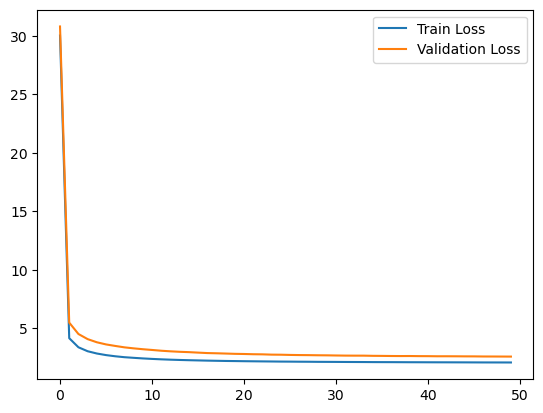

CPU times: total: 30.2 s
Wall time: 30.1 s


In [56]:
%%time

epochs = 50000
for epoch in range(epochs):

    # Create Minibatch
    ix = torch.randint(high=Xtr.shape[0], size=(minibatch_size,), generator=g, device=default_device)
    X = Xtr[ix]
    Y = Ytr[ix]
    
    # forward pass
    logits, loss = forwardPass(X, Y)
    
    if epoch % 1000 == 0:
        lossi_tr.append(estimateError(Xtr, Ytr, batch_size=-1))
        lossi_cv.append(estimateError(Xcv, Ycv, batch_size=-1))
        print(f"epoch:{epoch} \t Training loss: {lossi_tr[-1]} \t Validation Loss: {lossi_cv[-1]}")
    
    # Zero Grad
    for p in parameters:
        p.grad = None

    # Backward Pass
    loss.backward()

    # Update params
    for p in parameters:
        p.data -= (learning_rate * p.grad)


plt.plot(lossi_tr, label="Train Loss")
plt.plot(lossi_cv, label="Validation Loss")
plt.legend(loc="upper right")
plt.show()

#### Generate New Words

In [58]:
count = 10
max_characters = 10
words = []

with torch.no_grad():
    for i in range(count):
        w = []
        while len(w) < max_characters:
            context = [start_ch] * context_size

            x = torch.tensor(encode(context), device=default_device)
            logits, _ = forwardPass(x)
            probabilities = F.softmax(logits, dim=-1)

            ch = decode(torch.multinomial(probabilities, num_samples=1).item())
            if ch == start_ch:
                break

            w.append(ch)
            context.pop(0)
            context.append(ch)
        words.append("".join(w))

words

['mmlamdbard',
 'jyjkihvjmd',
 'dkmnhngljz',
 'kcajmhlmdd',
 'jdszdmedhk',
 'mkkjesdzss',
 'nmddabvrhh',
 'eaqvzmcmhy',
 'wneadsglpa',
 'lolmmmakac']